# MIST101 Pratical 3: Introduction to RNN (Part 1)

Welcome to the third tutorial of MIST101. The goal of this tutorial is to show how to use Tensorflow to train and evaluate simple recurrent neural networks for sequencial data prediction and MNIST.

## Price Prediction

In [1]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

# Generate price data
def gen_sequence(length):
    t = int(random.random() * 100.0)
    prices = []
    for i in range(t, t+length):
        prices.append([50 + 15*(math.sin(i * 0.6))+ random.random() * 1.0])
    return prices
    
def get_data(batch_size, step_size):
    data_input = []
    data_label = []
    for i in range(batch_size):
        prices = gen_sequence(step_size + 1)
        data_input.append(prices[:step_size])
        data_label.append(prices[1:])
    return np.array(data_input), np.array(data_label) 

## Data Visualization

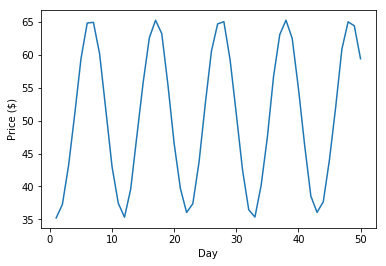

In [2]:
length = 50
sample_data_input, sample_data_label = get_data(1, length) # get one batch of data with length of 50
days = np.linspace(1, length, length)
plt.plot(days, sample_data_input[0,:,0]) # plot the data
plt.xlabel("Day")
plt.ylabel("Price ($)")

## Construct RNN Model

To construct the RNN model, we first need to construct the base model and the inputs

In [3]:
input_size = 1
output_size = 1
hidden_state_size = 10
batch_size = 100
step_size = 50 # back-propagate through t steps

# We initialize our placeholder across the sequence.  
input_placeholder = tf.placeholder(tf.float32, shape = (None, step_size, input_size))   # We can put "None" to make the size of the tensor flexible (batch size is variable)
label_placeholder = tf.placeholder(tf.float32, shape = (None, step_size, output_size)) 

# Define the weights/biases used in our RNN model
weight_in = tf.Variable(tf.truncated_normal(shape = [input_size, hidden_state_size], stddev = 0.01))
weight_hidden_in = tf.Variable(tf.truncated_normal(shape = [hidden_state_size, hidden_state_size], stddev = 0.01))
bias_hidden = tf.Variable(tf.zeros(shape = [hidden_state_size]))

weight_out = tf.Variable(tf.truncated_normal(shape = [hidden_state_size, output_size], stddev = 0.01))
bias_out = tf.Variable(tf.zeros(shape = [output_size]))

We can build the model which performs a linear transformation and a nonlinear transformation to the inputs: 
$$h_t = relu(W_{in}x_t + W_{hidden_in}h_{t-1} + b_{hidden})$$ 
$$y_t = W_{out}h_t + b_{out}$$
where $h_t$ is the hidden state feedback and $x_t$, $y_t$ are the inputs and outputs of the model respectively. The function below takes in two input tensors ($x_t$ and $h_{t-1}$) and returns two output tensors ($y_t$ and $h_t$)

In [4]:
def model(input, hidden_in):
    hidden_out = tf.nn.relu(tf.matmul(input, weight_in) + tf.matmul(hidden_in, weight_hidden_in) + bias_hidden)
    output = tf.matmul(hidden_out, weight_out) + bias_out
    return output, hidden_out

After constructing the model function, we can unfold our RNN model by various steps as following. Then, we can define our loss function and training step as follows

In [5]:
initial_state = state = tf.zeros([batch_size, hidden_state_size])
losses = []
for i in range(step_size):
    output, state = model(input_placeholder[:, i, :], state) # Unfolding the RNN model by feeding the output state tensor from previous step.
    losses.append(tf.reduce_mean(tf.squared_difference(output, label_placeholder[:, i, :]))) # Mean square error as loss function

loss = tf.add_n(losses) / step_size # Average the loss across sequence
train_step = tf.train.AdamOptimizer(0.01).minimize(loss) # Define training step

Now, we can train our model!

In [6]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for step in range(5000):
    batch_inputs, batch_labels = get_data(batch_size, step_size)                                    # Get a mini batch of images and labels
    _, loss_value = sess.run([train_step, loss], feed_dict = {input_placeholder : batch_inputs,  # Perform a training step
                                                              label_placeholder : batch_labels})
    # Display
    if step % 100 == 0:
        print('Step %d: loss = %.2f' % (step, loss_value))

Step 0: loss = 2655.77
Step 100: loss = 120.99
Step 200: loss = 86.44
Step 300: loss = 59.72
Step 400: loss = 44.28
Step 500: loss = 36.20
Step 600: loss = 31.77
Step 700: loss = 29.97
Step 800: loss = 29.81
Step 900: loss = 28.62
Step 1000: loss = 29.13
Step 1100: loss = 28.56
Step 1200: loss = 28.36
Step 1300: loss = 28.88
Step 1400: loss = 27.86
Step 1500: loss = 28.03
Step 1600: loss = 27.50
Step 1700: loss = 26.89
Step 1800: loss = 25.61
Step 1900: loss = 24.15
Step 2000: loss = 24.41
Step 2100: loss = 22.60
Step 2200: loss = 22.33
Step 2300: loss = 22.18
Step 2400: loss = 21.62
Step 2500: loss = 20.00
Step 2600: loss = 19.12
Step 2700: loss = 17.86
Step 2800: loss = 17.62
Step 2900: loss = 14.35
Step 3000: loss = 9.24
Step 3100: loss = 4.53
Step 3200: loss = 3.44
Step 3300: loss = 4.04
Step 3400: loss = 2.86
Step 3500: loss = 2.53
Step 3600: loss = 3.42
Step 3700: loss = 2.64
Step 3800: loss = 2.40
Step 3900: loss = 2.37
Step 4000: loss = 2.34
Step 4100: loss = 2.26
Step 4200: lo

## Model Visualization

To see how well our trained model actually performs, we use our model to generate 50 price predictions after giving 50 previous prices.

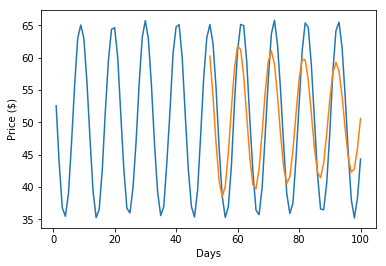

In [9]:
initial_steps = 50
prediction_steps = 50
initial_cond = get_data(1, prediction_steps + initial_steps)[0] # Get the sequencial data
state = np.zeros([1, hidden_state_size]) # Initialize the RNN hidden state

model_input = tf.placeholder(tf.float32, shape = (None, input_size))               # Define the placeholders for generation
model_state_input = tf.placeholder(tf.float32, shape = (None, hidden_state_size))
model_output, model_state_output = model(model_input, model_state_input)           # Define output tensors

record_given = []
record_pred = []

for i in range(initial_steps):   # Feed the first 50 data points into the model for processing
    _, state = sess.run([model_output, model_state_output], feed_dict = {model_input: initial_cond[:,i], model_state_input : state})
    record_given.append(initial_cond[0][i][0])

pre_output = initial_cond[:,initial_steps-1]
for i in range(prediction_steps): # Predict the following 50 data points
    pre_output, state = sess.run([model_output, model_state_output], feed_dict = {model_input: pre_output, model_state_input : state})
    record_pred.append(pre_output[0])
    record_given.append(initial_cond[0][i+initial_steps][0])

# Plot the prediction vs. actual prices
t_given = np.linspace(1, prediction_steps + initial_steps, prediction_steps + initial_steps)
t_pred = np.linspace(initial_steps + 1, initial_steps + prediction_steps, prediction_steps)
plt.plot(t_given, record_given, t_pred, record_pred)
plt.xlabel("Days")
plt.ylabel("Price ($)")